# dataset

Define the event of interest

For survival analysis, we want to model “time from BC to contract signature.”

Start = BC date (from your LEAD_CREATION_DATE or the first BC_* timestamp, depending on business definition).

End = CONTRACT_SIGNED date if present → event=1.

If no contract: censored at last_seen_date (e.g. last BC, last FU, or dataset cut-off date) → event=0.

In [10]:
import pandas as pd

path1 = r"C:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\Data_raw\lead_time_after_march.csv"
df1 = pd.read_csv(path1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18004 entries, 0 to 18003
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       18004 non-null  int64  
 1   LEAD_CREATION_DATE       18004 non-null  object 
 2   SC1_SCHEDULED            11736 non-null  object 
 3   SC1_APPOINTMENT          11736 non-null  object 
 4   LAST_FU                  10836 non-null  object 
 5   NEXT_FU                  2425 non-null   object 
 6   CONTRACT_SIGNED          680 non-null    object 
 7   WITHDRAWAL               130 non-null    object 
 8   IPA_SCHEDULED            583 non-null    object 
 9   IPA_DAY                  510 non-null    object 
 10  MOVED2OPS                423 non-null    object 
 11  NET_TBK                  248 non-null    object 
 12  POST_IPA_CALL            509 non-null    object 
 13  SELF_IPA_PV              0 non-null      float64
 14  SELF_IPA_HP           

In [11]:
path2 = r"C:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\Data_raw\info_client.csv"
df2 = pd.read_csv(path2)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126364 entries, 0 to 126363
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   REQUESTID               126364 non-null  int64  
 1   ZIPREGION               123309 non-null  object 
 2   EVALUATIONTIME          119666 non-null  object 
 3   DESIREDINSTALLATIONEND  119746 non-null  object 
 4   ELECTRICITYBILL         105783 non-null  float64
 5   HEATINGBILL             92431 non-null   float64
 6   MKTGPARAMSCORE          24088 non-null   object 
 7   GROSSCONTRACTSIGNED     2781 non-null    float64
 8   SELFIPAIMPORTEDAT       2619 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 8.7+ MB


In [5]:
path3 = r"C:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\Data_raw\sc_from_march.csv"
df3 = pd.read_csv(path3)

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126364 entries, 0 to 126363
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   REQUESTID               126364 non-null  int64  
 1   ZIPREGION               123309 non-null  object 
 2   EVALUATIONTIME          119666 non-null  object 
 3   DESIREDINSTALLATIONEND  119746 non-null  object 
 4   ELECTRICITYBILL         105783 non-null  float64
 5   HEATINGBILL             92431 non-null   float64
 6   MKTGPARAMSCORE          24088 non-null   object 
 7   GROSSCONTRACTSIGNED     2781 non-null    float64
 8   SELFIPAIMPORTEDAT       2619 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 8.7+ MB


## dataprep

In [13]:
# we will use info from leadtime that has lead creation, call details and also contract signature

In [14]:
df= df1.copy()

In [15]:
import pandas as pd

df['LEAD_CREATION_DATE'] = pd.to_datetime(df['LEAD_CREATION_DATE'])
df['CONTRACT_SIGNED'] = pd.to_datetime(df['CONTRACT_SIGNED'], errors='coerce')
df['LAST_FU'] = pd.to_datetime(df['LAST_FU'], errors='coerce')
df['LAST_OUTCOME'] = pd.to_datetime(df['LAST_OUTCOME'], errors='coerce')

# pick censor date: contract date if signed, else last FU/outcome, else dataset max date
cutoff_date = df['LEAD_CREATION_DATE'].max()
df['end_date'] = df['CONTRACT_SIGNED'].fillna(df['LAST_FU']).fillna(df['LAST_OUTCOME']).fillna(cutoff_date)

# duration (days) and event flag
df['duration'] = (df['end_date'] - df['LEAD_CREATION_DATE']).dt.days
df['event'] = df['CONTRACT_SIGNED'].notnull().astype(int)

print(df[['duration','event']].describe())


           duration         event
count  18004.000000  18004.000000
mean     100.076150      0.037769
std       90.761909      0.190643
min     -200.000000      0.000000
25%       36.000000      0.000000
50%       75.000000      0.000000
75%      139.000000      0.000000
max      665.000000      1.000000


C:\Users\ElifYilmaz\AppData\Local\Temp\ipykernel_27932\3487525515.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['LAST_OUTCOME'] = pd.to_datetime(df['LAST_OUTCOME'], errors='coerce')


In [ ]:
# problematic entries --> only 2 
wrong = df[df['duration'] < 0][['ID','LEAD_CREATION_DATE','CONTRACT_SIGNED','LAST_FU','LAST_OUTCOME','end_date','duration']]
print(wrong.head(20))
print("Total wrong rows:", wrong.shape[0])


         ID LEAD_CREATION_DATE CONTRACT_SIGNED    LAST_FU LAST_OUTCOME  \
826   62538         2024-09-18      2024-07-04 2025-03-26          NaT   
1101  85638         2025-01-04             NaT 2024-06-18          NaT   

       end_date  duration  
826  2024-07-04       -76  
1101 2024-06-18      -200  
Total wrong rows: 2


In [17]:
df = df[df['duration'] >= 0].copy()


## Kaplan Meier

### Global view, beginning to contract

In [ ]:
#pip install lifelines


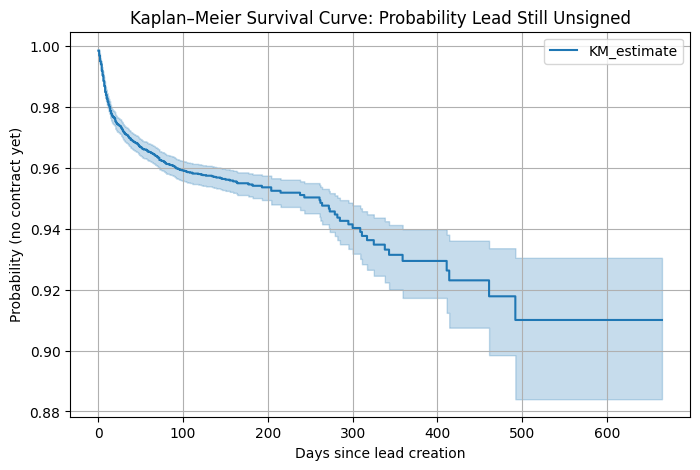

In [19]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# set up Kaplan–Meier
kmf = KaplanMeierFitter()

# fit on your survival table
kmf.fit(durations=df['duration'], event_observed=df['event'])

# plot
plt.figure(figsize=(8,5))
kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier Survival Curve: Probability Lead Still Unsigned")
plt.xlabel("Days since lead creation")
plt.ylabel("Probability (no contract yet)")
plt.grid(True)
plt.show()


### 2 Layer survival

#### Creation --> SC

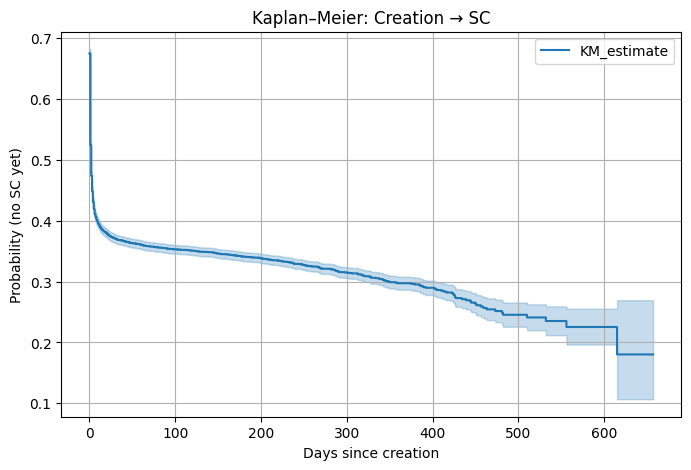

SC event rate: 0.6515210499972193


In [22]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# --- Stage 1: Creation → SC ---
df['SC1_SCHEDULED'] = pd.to_datetime(df['SC1_SCHEDULED'], errors='coerce')

# censor date for SC = if SC not reached, fallback to FU/outcome/cutoff
df['end_sc'] = df['SC1_SCHEDULED'].fillna(df['LAST_FU']).fillna(df['LAST_OUTCOME']).fillna(cutoff_date)

df['duration_sc'] = (df['end_sc'] - df['LEAD_CREATION_DATE']).dt.days
df['event_sc'] = df['SC1_SCHEDULED'].notnull().astype(int)

# clean negatives
df_stage1 = df[df['duration_sc'] >= 0].copy()

# KM curve
kmf_sc = KaplanMeierFitter()
kmf_sc.fit(durations=df_stage1['duration_sc'], event_observed=df_stage1['event_sc'])

plt.figure(figsize=(8,5))
kmf_sc.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier: Creation → SC")
plt.xlabel("Days since creation")
plt.ylabel("Probability (no SC yet)")
plt.grid(True)
plt.show()

print("SC event rate:", df_stage1['event_sc'].mean())


#### SC --> Contract

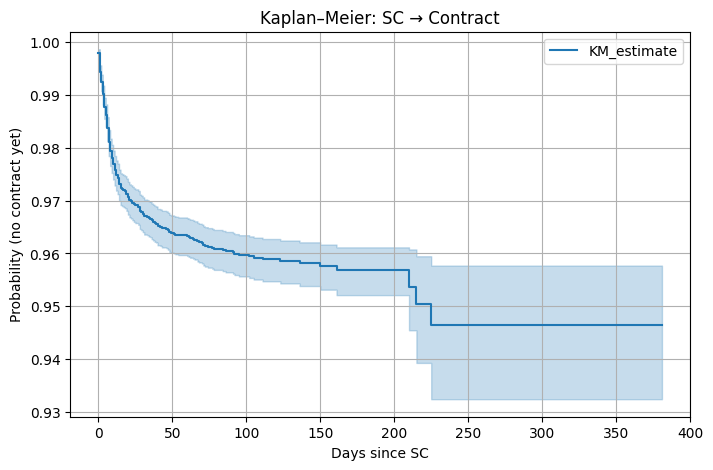

Contract event rate after SC: 0.03658119658119658


In [21]:
# restrict only to leads that reached SC
mask_sc = df['SC1_SCHEDULED'].notnull()
df_sc = df[mask_sc].copy()

# censor date for contract = contract date if signed, else FU/outcome/cutoff
df_sc['end_contract'] = df_sc['CONTRACT_SIGNED'].fillna(df_sc['LAST_FU']).fillna(df_sc['LAST_OUTCOME']).fillna(cutoff_date)

df_sc['duration_contract'] = (df_sc['end_contract'] - df_sc['SC1_SCHEDULED']).dt.days
df_sc['event_contract'] = df_sc['CONTRACT_SIGNED'].notnull().astype(int)

# clean negatives
df_stage2 = df_sc[df_sc['duration_contract'] >= 0].copy()

# KM curve
kmf_contract = KaplanMeierFitter()
kmf_contract.fit(durations=df_stage2['duration_contract'], event_observed=df_stage2['event_contract'])

plt.figure(figsize=(8,5))
kmf_contract.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier: SC → Contract")
plt.xlabel("Days since SC")
plt.ylabel("Probability (no contract yet)")
plt.grid(True)
plt.show()

print("Contract event rate after SC:", df_stage2['event_contract'].mean())
